In [1]:
import pandas as pd
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

base_dir = "/content/drive/MyDrive/Voiseed_task/LibriSpeech"
audio_dir = os.path.join(base_dir, "dev-clean/")
speaker_file = os.path.join(base_dir, "SPEAKERS.TXT")

In [4]:
speakers_file = "/content/drive/MyDrive/Voiseed_task/LibriSpeech/SPEAKERS.TXT"

with open(speakers_file, "r") as f:
    lines = [line.strip() for line in f.readlines() if not line.startswith(";")]

In [5]:
# Extract speaker information (ID, gender, subset) from text lines
speaker_data = []
for line in lines:
    parts = line.split("|")
    speaker_id = parts[0].strip()
    gender = parts[1].strip()
    subset = parts[2].strip()
    speaker_data.append((speaker_id, gender, subset))

# Convert extracted data into a structured DataFrame
df_speakers = pd.DataFrame(speaker_data, columns=["Speaker_ID", "Gender", "Subset"])

# Filter only speakers from the "dev-clean" subset
df_dev_clean = df_speakers[df_speakers["Subset"] == "dev-clean"]

# Select a balanced subset: 9 male and 9 female speakers
df_male = df_dev_clean[df_dev_clean["Gender"] == "M"].head(9)
df_female = df_dev_clean[df_dev_clean["Gender"] == "F"].head(9)
df_sampled = pd.concat([df_male, df_female]).reset_index(drop=True)

# Display the final sampled dataset
display(df_sampled)

,Speaker_ID,Gender,Subset
0,174,M,dev-clean
1,251,M,dev-clean
2,422,M,dev-clean
3,652,M,dev-clean
4,777,M,dev-clean
5,1272,M,dev-clean
6,2078,M,dev-clean
7,2086,M,dev-clean
8,2428,M,dev-clean
9,84,F,dev-clean


In [6]:
audio_dir = "/content/drive/MyDrive/Voiseed_task/LibriSpeech/dev-clean"

# Parameters for MFCC extraction
n_mfcc = 13  # Number of MFCC features
sr = 16000  # Sampling rate for audio processing

def extract_mfcc(file_path, n_mfcc=n_mfcc, sr=sr):
    """
    Extracts MFCC features from an audio file.
    - Loads the audio file with the specified sampling rate.
    - Computes MFCC features.
    - Returns the mean of MFCCs across time frames (fixed-size representation).
    """
    w, sr = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=w, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)

In [7]:
features = []
labels = []

# Iterate through the sampled dataset to process each speaker's audio files
for _, row in df_sampled.iterrows():
    speaker_id = row["Speaker_ID"]
    gender = row["Gender"]
    speaker_folder = os.path.join(audio_dir, str(speaker_id))
    # Iterate through chapters within the speaker's folder
    for chapter in os.listdir(speaker_folder):
        chapter_folder = os.path.join(speaker_folder, chapter)
        # Iterate through audio files in the chapter
        for file in os.listdir(chapter_folder):
            if file.endswith(".flac"):
                file_path = os.path.join(chapter_folder, file)
                mfcc = extract_mfcc(file_path, n_mfcc=n_mfcc)
                features.append(mfcc)
                labels.append(gender)

print(labels[:10])
X = np.array(features)
y = np.array(labels)

print(f"Extracted MFCC features shape: {X.shape}, Labels shape: {y.shape}")

['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M']
Extracted MFCC features shape: (349, 13), Labels shape: (349,)


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
print(X_scaled)

[[-1.9549223   0.481964   -0.84539825 ... -1.0826141  -2.245857
  -0.7524722 ]
 [-1.0327951   0.08165001 -0.91690344 ... -0.99308306 -2.0743291
  -0.49862573]
 [-2.8418021  -0.10245834 -0.05701597 ...  0.19750293 -1.7005142
  -0.06125935]
 ...
 [-0.15255123  2.199865   -0.7911116  ...  1.632979    0.16459174
   1.175053  ]
 [ 0.40658808  2.373193   -0.6909798  ...  0.7862521  -0.3637281
   0.79762286]
 [-0.39976797  1.9145877  -0.39215833 ...  0.7150547  -0.5058155
   1.1034797 ]]


In [10]:
X_scaled.shape

(349, 13)

**Feature distribution**

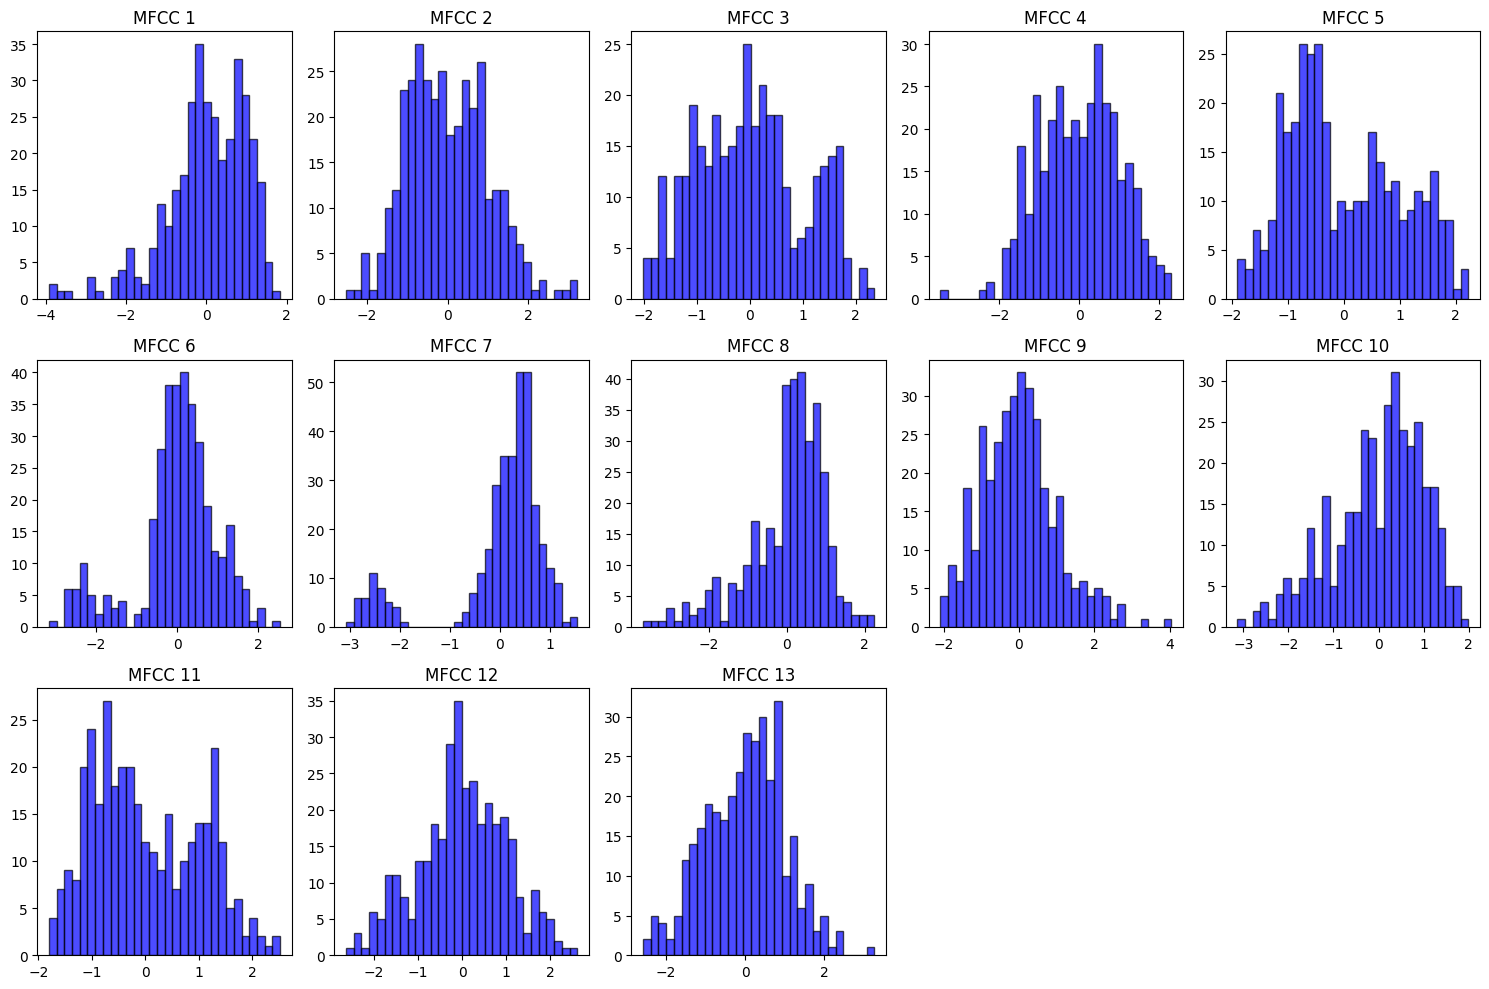

In [11]:
plt.figure(figsize=(15, 10))
for i in range(13):
    plt.subplot(3, 5, i + 1)
    plt.hist(X_scaled[:, i], bins=30, alpha=0.7, color='b', edgecolor='black')
    plt.title(f'MFCC {i+1}')
plt.tight_layout()
plt.show()

**Boxplot to identify outliers**

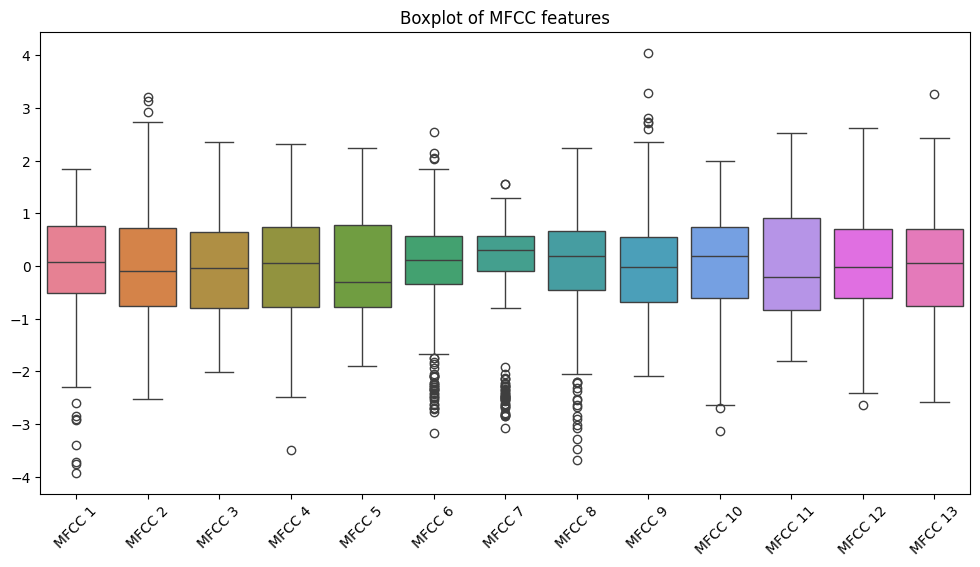

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_scaled)
plt.xticks(range(13), [f'MFCC {i+1}' for i in range(13)], rotation=45)
plt.title("Boxplot of MFCC features")
plt.show()

**Analysis of the correlation between MFCC and gender**

In [13]:
df_mfcc = pd.DataFrame(X_scaled, columns=[f'MFCC {i+1}' for i in range(13)])
df_mfcc["Gender"] = y

In [14]:
print(df_mfcc)

       MFCC 1    MFCC 2    MFCC 3    MFCC 4    MFCC 5    MFCC 6    MFCC 7  \
0   -1.954922  0.481964 -0.845398 -0.893183 -1.097527  1.045647  0.340232   
1   -1.032795  0.081650 -0.916903 -1.307150 -1.039843  1.457469  0.199822   
2   -2.841802 -0.102458 -0.057016 -0.777272 -0.012303  1.836113  0.700816   
3   -1.966681  1.373513 -1.164926 -2.163619 -1.067636  1.565937  0.500838   
4   -2.294826  0.281051 -0.517309 -1.136344 -0.815523  1.178424  0.384622   
..        ...       ...       ...       ...       ...       ...       ...   
344 -0.174921  1.434482 -1.016539  1.128807 -0.274332  0.875113  0.489579   
345 -0.129511  1.748617 -0.987569  2.150723 -0.872740  0.711284  0.605808   
346 -0.152551  2.199865 -0.791112  1.188228 -0.462065  1.627337  0.904343   
347  0.406588  2.373193 -0.690980  0.790904 -1.809055  1.189819  0.783867   
348 -0.399768  1.914588 -0.392158  1.484380 -0.353197  0.826903  0.738229   

       MFCC 8    MFCC 9   MFCC 10   MFCC 11   MFCC 12   MFCC 13 Gender  
0 

In [15]:
summary_stats = df_mfcc.groupby("Gender").agg(["mean", "std"])

In [16]:
print(summary_stats.iloc[:,:14])
print(summary_stats.iloc[:,14:])

          MFCC 1              MFCC 2              MFCC 3              MFCC 4  \
            mean       std      mean       std      mean       std      mean   
Gender                                                                         
F       0.112695  0.903523  0.107379  1.067150 -0.262761  0.758613  0.580456   
M      -0.185264  1.123588 -0.176525  0.857843  0.431964  1.188625 -0.954235   

                    MFCC 5              MFCC 6             MFCC 7            
             std      mean       std      mean       std     mean       std  
Gender                                                                       
F       0.691648 -0.210528  0.686001 -0.339652  1.013001 -0.31239  1.129933  
M       0.632228  0.346096  1.301560  0.558367  0.683273  0.51355  0.362695  
          MFCC 8              MFCC 9             MFCC 10             MFCC 11  \
            mean       std      mean       std      mean       std      mean   
Gender                                           

**distribution of MFCCs by gender**

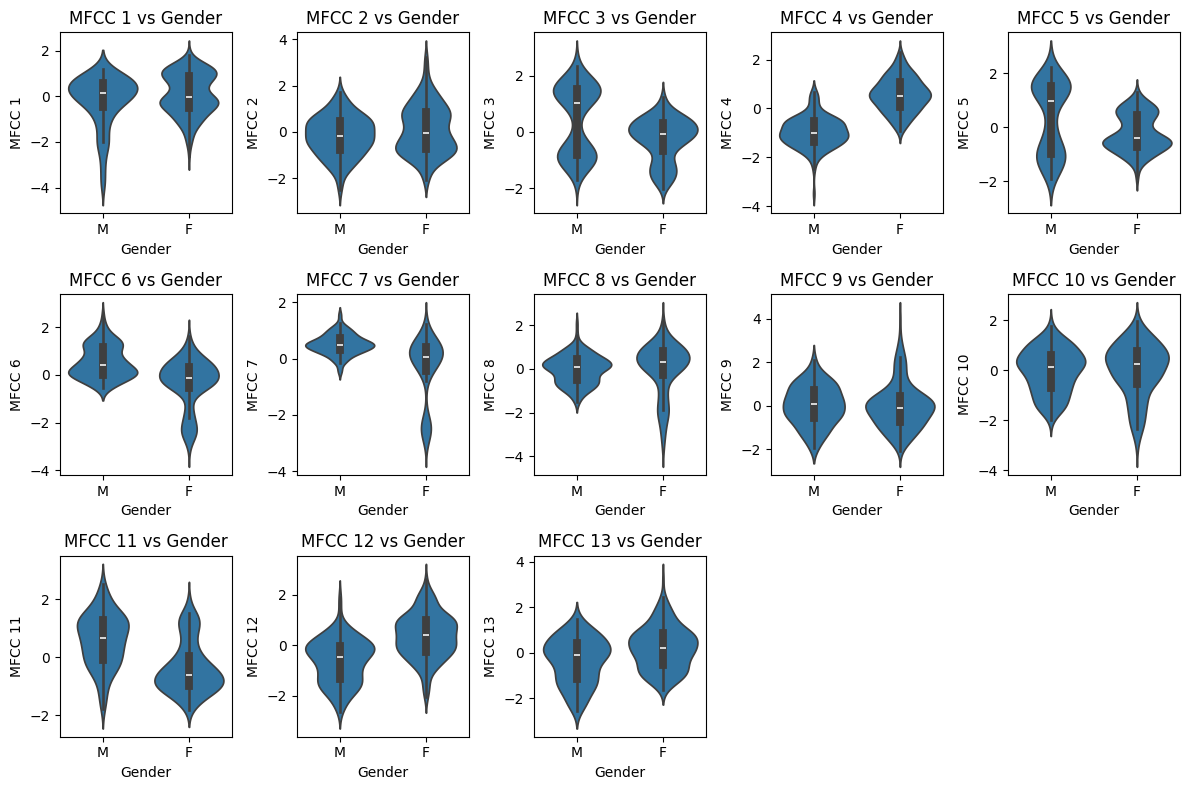

In [17]:
plt.figure(figsize=(12, 8))
for i in range(13):
    plt.subplot(3, 5, i + 1)
    sns.violinplot(x="Gender", y=f"MFCC {i+1}", data=df_mfcc)
    plt.title(f'MFCC {i+1} vs Gender')
plt.tight_layout()
plt.show()

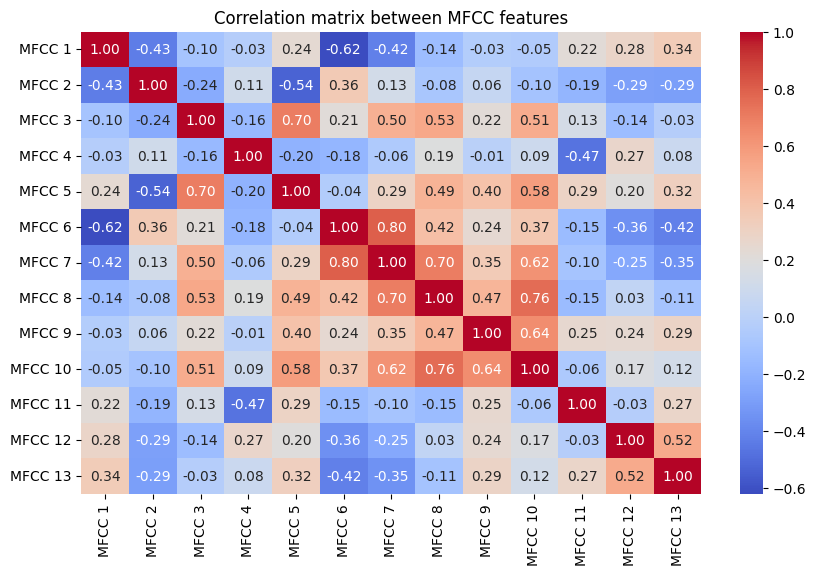

In [18]:
plt.figure(figsize=(10, 6))
corr_matrix = df_mfcc.iloc[:, :-1].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix between MFCC features")
plt.show()

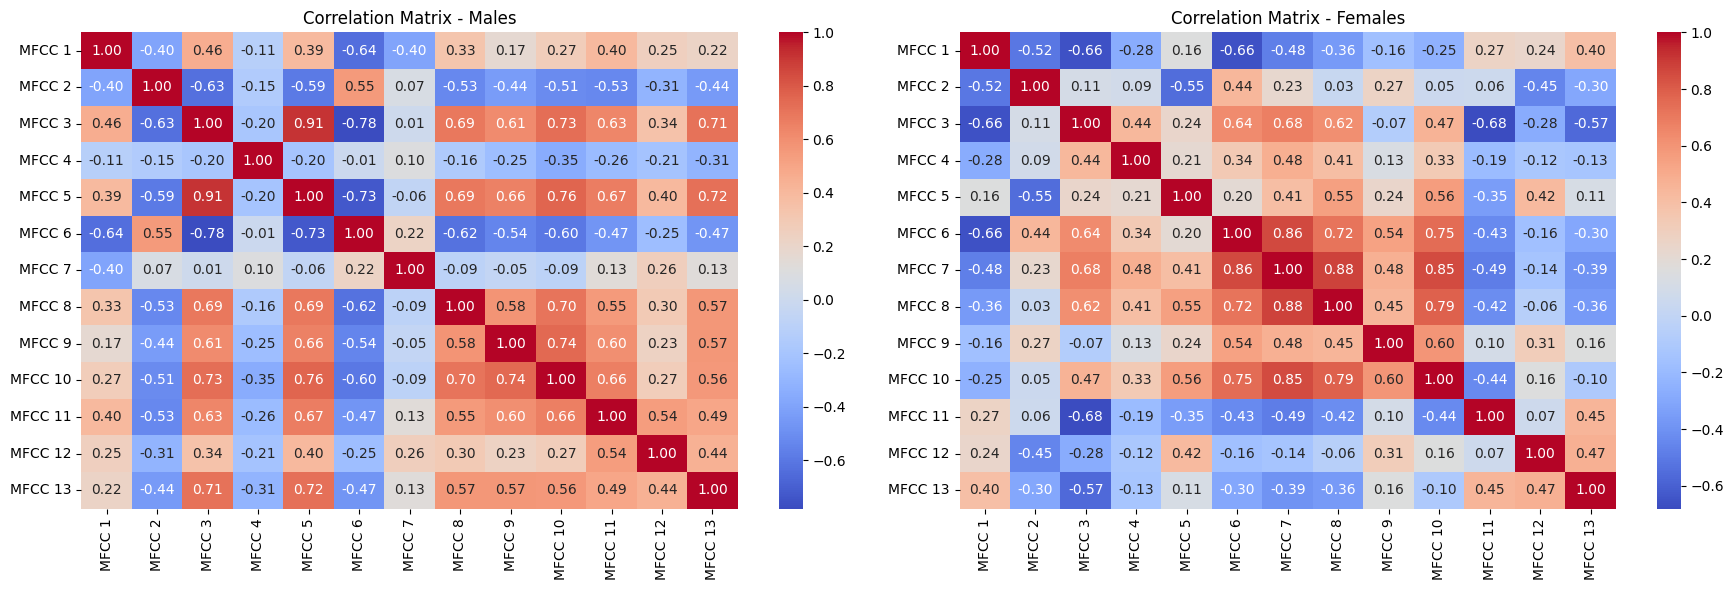

In [19]:
corr_matrix_male = df_mfcc[df_mfcc["Gender"] == "M"].iloc[:, :-1].corr()
corr_matrix_female = df_mfcc[df_mfcc["Gender"] == "F"].iloc[:, :-1].corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(corr_matrix_male, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title("Correlation Matrix - Males")

sns.heatmap(corr_matrix_female, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
axes[1].set_title("Correlation Matrix - Females")

plt.tight_layout()
plt.show()

In [20]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)
print(y, y_encoded)

# Split the dataset into training and testing sets (80% train, 20% test)
# Stratification ensures the class distribution is maintained in both sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")


['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F

## Models

In [21]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (279, 13), Test set: (70, 13)


**Naïve baseline → Logistic Regression**

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)

**Sophisticated baseline → Support Vector Machine (SVM)**

In [23]:
from sklearn.svm import SVC

svm = SVC(kernel="linear", C=1)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

**Neural Network (MLP) → Multi-Layer Perceptron**

In [24]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", solver="adam", max_iter=500)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

**Deep Learning Model (CNN) → Convolutional Neural Network**

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

X_train_cnn = X_train.reshape(X_train.shape[0], 13, 1, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], 13, 1, 1)

cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 1), activation='relu', input_shape=(13, 1, 1)),
    layers.MaxPooling2D((2, 1)),
    layers.Conv2D(64, (3, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.6451 - loss: 0.6712 - val_accuracy: 0.6286 - val_loss: 0.6190
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6420 - loss: 0.6191 - val_accuracy: 0.8000 - val_loss: 0.5591
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8082 - loss: 0.5369 - val_accuracy: 0.9000 - val_loss: 0.4741
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9666 - loss: 0.4319 - val_accuracy: 0.9857 - val_loss: 0.3695
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9866 - loss: 0.3340 - val_accuracy: 0.9571 - val_loss: 0.2610
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9948 - loss: 0.2188 - val_accuracy: 0.9857 - val_loss: 0.1773
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9809 - loss: 0.1414 - val_accuracy: 0.9857 - val_loss: 0.1166
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9934 - loss: 0.1113 - val_accuracy: 0.9857 - val_loss: 0.0874
Epo

**REPORT**

In [ ]:
from sklearn.metrics import classification_report

report_log_reg = classification_report(y_test, y_pred_log, output_dict=True)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
report_mlp = classification_report(y_test, y_pred_mlp, output_dict=True)

y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")
report_cnn = classification_report(y_test, y_pred_cnn, output_dict=True)

df_log_reg = pd.DataFrame(report_log_reg).transpose()
df_svm = pd.DataFrame(report_svm).transpose()
df_mlp = pd.DataFrame(report_mlp).transpose()
df_cnn = pd.DataFrame(report_cnn).transpose()

In [ ]:
print("Logistic Regression Report:\n", df_log_reg)
print("\nSVM Report:\n", df_svm)

In [ ]:
print("\nMLP Report:\n", df_mlp)
print("\nCNN Report:\n", df_cnn)

In [ ]:
import pickle
file_path = "/content/drive/MyDrive/Voiseed_task/df_sampled.pkl"
with open(file_path, "wb") as f:
    pickle.dump(df_sampled, f)

# Part 2

In [ ]:
import librosa
import numpy as np
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
with open(file_path, "rb") as f:
    df_sampled = pickle.load(f)
print(df_sampled.head())

In [ ]:
def extract_wav2vec_features(file_path, model, processor, chunk_duration=2.0, sr=16000):
    """
    Extracts Wav2Vec2 embeddings from an audio file.

    - Splits the audio into fixed-length chunks (default: 2 seconds).
    - Processes each chunk with Wav2Vec2 to generate feature embeddings.
    - Returns an array of extracted features.
    """

    # Load the audio file with the specified sampling rate
    y, _ = librosa.load(file_path, sr=sr)

    # Define chunk size in samples
    chunk_size = int(sr * chunk_duration)

    # Split the audio into consecutive chunks of fixed size
    chunks = [y[i:i+chunk_size] for i in range(0, len(y), chunk_size) if len(y[i:i+chunk_size]) == chunk_size]

    features = []
    for chunk in chunks:
        # Convert audio chunk to input format for Wav2Vec2
        inputs = processor(chunk, return_tensors="pt", sampling_rate=sr).input_values.to(device)

        # Extract embeddings from the Wav2Vec2 model
        with torch.no_grad():
            embeddings = model(inputs).last_hidden_state.mean(dim=1).cpu().numpy()

        # Store flattened embeddings
        features.append(embeddings.flatten())

    return np.array(features)

features = []
labels = []

In [ ]:
# Iterate through the sampled dataset to extract features from each speaker's audio files
for _, row in df_sampled.iterrows():
    speaker_id = row["Speaker_ID"]
    speaker_label = speaker_id  # Speaker ID is used as the class label

    # Construct path to the speaker's folder
    speaker_folder = os.path.join(audio_dir, str(speaker_id))

    # Iterate through chapters within the speaker's folder
    for chapter in os.listdir(speaker_folder):
        chapter_folder = os.path.join(speaker_folder, chapter)

        # Iterate through audio files in the chapter
        for file in os.listdir(chapter_folder):
            if file.endswith(".flac"):  # Process only FLAC audio files
                audio_file_path = os.path.join(chapter_folder, file)

                # Extract Wav2Vec2 features from the audio file
                emb = extract_wav2vec_features(audio_file_path, model, processor)

                # Store extracted embeddings and corresponding speaker label
                for e in emb:
                    features.append(e)
                    labels.append(speaker_label)

X = np.array(features)
y = np.array(labels)

print(f"Extracted Features Shape: {X.shape}, Labels Shape: {y.shape}")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# SVM
svm = SVC(kernel="linear", C=1)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("\nRandom Forest:\n", classification_report(y_test, y_pred_rf))
print("\nSVM:\n", classification_report(y_test, y_pred_svm))

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Speaker"] = y

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Speaker", palette="coolwarm", data=df_pca, alpha=0.7)
plt.title("PCA Visualization of Speaker Embeddings")
plt.show()


Github Repo

In [ ]:
%cd /content/drive/MyDrive/
!git clone https://github.com/LosaLosSantos/Speaker-Classification.git

In [ ]:
%cd /content/drive/MyDrive/Speaker-Classification

In [ ]:
import shutil

source_dir = "/content/drive/MyDrive/Voiseed_task/"
repo_dir = "/content/drive/MyDrive/Speaker-Classification/"

shutil.copy(source_dir + "DSP.ipynb", repo_dir + "DSP.ipynb")
shutil.copy(source_dir + "df_sampled.pkl", repo_dir + "df_sampled.pkl")
shutil.copy(source_dir + "LibriSpeech/SPEAKERS.TXT", repo_dir + "SPEAKERS.TXT")

In [ ]:
!git add .
!git commit -m "1"

In [ ]:
!git push origin main